# Basic Usage of reLAISS
### Authors: Evan Reynolds and Alex Gagliano

## Introduction

reLAISS is the second version of LAISS (Lightcurve Anomaly Identification & Similarity Search); a tool to find similar supernovae & identify anomalous supernovae (and the galaxies that host them) using their photometric features.

The similarity search takes advantage of [Approximate Nearest Neighbors Oh Yeah (ANNOY)](https://github.com/spotify/annoy), the approximate nearest neighbors algorithm developed by Spotify that allows you to come up with a relevant song to listen to before your current one ends. The anomaly detection classifier is an isolation forest model trained on a dataset bank of over 22,000 transients.

This notebook demonstrates the basic features of the reLAISS library for finding similar astronomical transients.

## Topics Covered
1. Initializing the ReLAISS client
2. Loading reference data
3. Finding optimal number of neighbors
4. Basic nearest neighbor search
5. Using Monte Carlo simulations and feature weighting
6. Basic anomaly detection

## Setup

First, let's import the required packages and create the necessary output directories:

In [6]:
import os
import pandas as pd
import relaiss

# Create output directories
os.makedirs('./figures', exist_ok=True)
os.makedirs('./sfddata-master', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./timeseries', exist_ok=True)

%matplotlib inline

## 1. Initialize the ReLAISS Client

First, we create an instance of the ReLAISS client that we'll use to find similar transients.

In [3]:
# Create ReLAISS client
client = relaiss.ReLAISS()

## 2. Load Reference Data

Next, we load the reference dataset bank. This contains the features of known transients that we'll use for comparison.

The `load_reference` function will automatically download the SFD dust map files if they don't exist in the specified directory. These files are required for extinction corrections in the reLAISS pipeline.

In [4]:
# Load reference data
client.load_reference(
    path_to_sfd_folder='./sfddata-master',  # Directory for SFD dust maps
    use_pca=False,  # Don't use PCA for this example
    host_features= ["gKronMagCorrected", "gKronRad", "gExtNSigma",  "rKronMagCorrected",  "rKronRad",  "iKronMagCorrected", "zKronMagCorrected", "zKronRad"],
    force_recreation_of_index=True
)

Loading preprocessed reference bank from cache...
Building search index...
Building new NGT index with 25515 transients...
Done!



## 3. Finding the Optimal Number of Neighbors

Before doing a full neighbor search, we can use reLAISS to suggest an optimal number of neighbors based on the distance distribution. This helps avoid arbitrary choices for the number of neighbors to return.

First, let's run a search with a larger number of neighbors and set `suggest_neighbor_num=True`. This will show us a distance plot that helps identify a reasonable cutoff point for similar objects.

There are host features, snagging from the light curve ID!
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_8host_1weight.ngt 


Found input transient at index 0, removing it...

ANN elapsed time: 0.011 s
Total elapsed time: 0.011 s

Suggested number of neighbors is 5, chosen by comparing 40 neighbors.
Saved neighbor distances plot to ./figures/neighbor_dist_plots/n=40


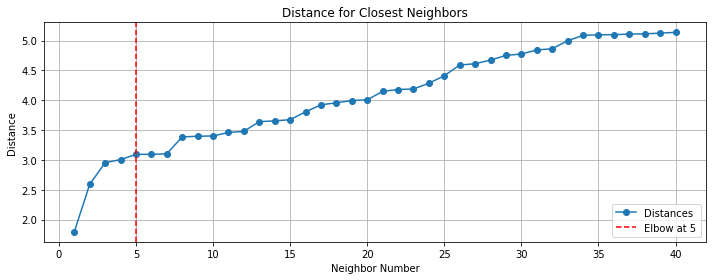

Stopping nearest neighbor search after suggesting neighbor number. Set suggest_neighbor_num=False for full search.



In [4]:
# Find optimal number of neighbors
client.find_neighbors(
    ztf_object_id='ZTF21aaublej',  # ZTF ID to find neighbors for
    n=40,  # Search in a larger pool
    suggest_neighbor_num=True,  # Only suggest optimal number, don't return neighbors
    plot=True,  # Show the distance elbow plot
    save_figures=True,  # Save plots to disk
    path_to_figure_directory='./figures'
)

There are host features, snagging from the light curve ID!
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_8host_1weight.ngt 


Found input transient at index 0, removing it...

ANN elapsed time: 0.011 s
Total elapsed time: 0.011 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21aaublej  2021ixf    SN Ia      0.041

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21aaublej.png


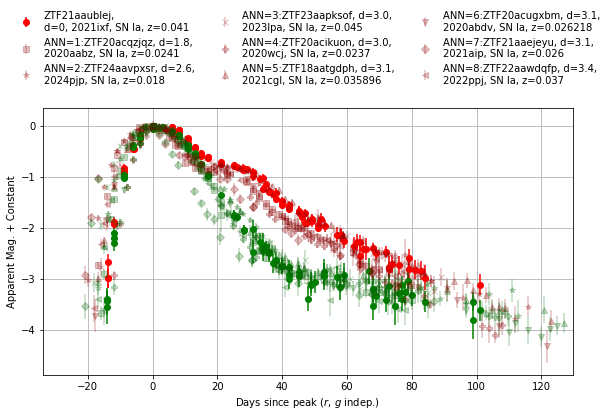


Generating hosts grid plot...


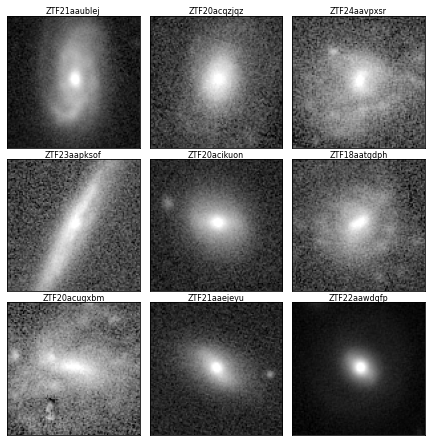

PDF written to figures/host_grids/ZTF21aaublej_host_thumbnails_ann=8.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20acqzjqz  2020aabz SN Ia        0.024  1.795  https://alerce.online/object/ZTF20acqzjqz
2    ZTF24aavpxsr  2024pjp  SN Ia        0.018  2.589  https://alerce.online/object/ZTF24aavpxsr
3    ZTF23aapksof  2023lpa  SN Ia        0.045  2.955  https://alerce.online/object/ZTF23aapksof
4    ZTF20acikuon  2020wcj  SN Ia        0.024  3.005  https://alerce.online/object/ZTF20acikuon
5    ZTF18aatgdph  2021cgl  SN Ia        0.036  3.094  https://alerce.online/object/ZTF18aatgdph
6    ZTF20acugxbm  2020abdv SN Ia        0.026  3.094  https://alerce.online/object/ZTF20acugxbm
7    ZTF21aaejeyu  2021aip  SN Ia        0.026  3.102  https://alerce.online/object/ZTF21aaejeyu
8    ZTF22aawdqfp  2022ppj  SN Ia        0.037  3.387  https://alerce.online/object/ZTF22aawdqfp


In [5]:
# Find nearest neighbors
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21aaublej',  # ZTF ID to find neighbors for
    n=8,  # Number of neighbors to return
    suggest_neighbor_num=False,  # Return actual neighbors
    plot=True,  # Generate diagnostic plots
    save_figures=True,  # Save plots to disk
    path_to_figure_directory='./figures'
)

## 5. Using Monte Carlo Simulations and Feature Weighting

reLAISS allows you to adjust the relative importance of lightcurve features compared to host galaxy features using the `weight_lc_feats_factor` parameter. A value greater than 1.0 will make lightcurve features more important in the similarity search.

The Monte Carlo simulation functionality (`num_sims` parameter) helps account for measurement uncertainties by running multiple simulations with perturbed feature values. For features that don't have corresponding error columns in the dataset, reLAISS will automatically use a default error of 10% of the feature value.

If you find that your matches aren't quite what you're looking for, you can try:
- Using Monte Carlo simulations to account for feature measurement uncertainties
- Upweighting lightcurve features to focus more on the transient's photometric properties than its host
- Removing host features entirely for a "lightcurve-only" search
- Removing lightcurve features for a "host-only" search

Let's try using Monte Carlo simulations with upweighted lightcurve features:

Loading preprocessed reference bank from cache...
Building search index...
Loading previously saved NGT index...
Done!

There are host features, snagging from the light curve ID!
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_8host_50000weight.ngt 

Upweighting light curve features by a factor of 50000.0.

Number of unique neighbors found through monte carlo: 6.
Picking top 5 neighbors.

Found input transient at index 0, removing it...

ANN elapsed time: 0.014 s
Total elapsed time: 0.014 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21aaublej  2021ixf    SN Ia      0.041

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21aaublej.png


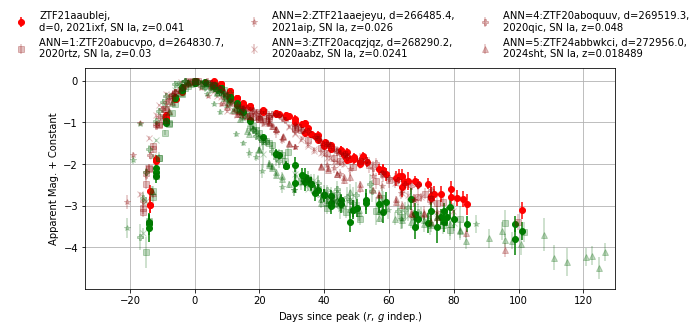


Generating hosts grid plot...


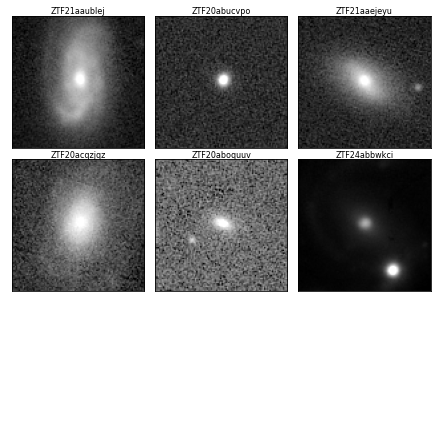

PDF written to figures/host_grids/ZTF21aaublej_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF20abucvpo  2020rtz  SN Ia        0.030 264830.656  https://alerce.online/object/ZTF20abucvpo
2    ZTF21aaejeyu  2021aip  SN Ia        0.026 266485.375  https://alerce.online/object/ZTF21aaejeyu
3    ZTF20acqzjqz  2020aabz SN Ia        0.024 268290.188  https://alerce.online/object/ZTF20acqzjqz
4    ZTF20aboquuv  2020qic  SN Ia        0.048 269519.312  https://alerce.online/object/ZTF20aboquuv
5    ZTF24abbwkci  2024sht  SN Ia        0.018 272955.969  https://alerce.online/object/ZTF24abbwkci


In [7]:
# Use feature weighting -- need to rebuild the index 
client.load_reference(
    path_to_sfd_folder='./sfddata-master',  
    use_pca=False,
    weight_lc=50000.0,
    host_features= ["gKronMagCorrected", "gKronRad", "gExtNSigma",  "rKronMagCorrected",  "rKronRad",  "iKronMagCorrected", "zKronMagCorrected", "zKronRad"],
)


# Using Monte Carlo simulations
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21aaublej',  
    n=5,
    num_sims=50, 
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

## 6. Basic Anomaly Detection

reLAISS also includes tools for anomaly detection that can help identify unusual transients. The anomaly detection module uses an Isolation Forest algorithm to identify outliers in the feature space.

The anomaly detection process will produce plots showing the lightcurve of the input transient and a graph of the probability (in time) that the transient is anomalous. If the probability exceeds 50% at any epoch, the transient is flagged as anomalous.

### Running Anomaly Detection on a Transient

We can jointly train and run anomaly detection on a specific transient to see if it's considered anomalous:

Running reLAISS in anomaly detection mode:

Training new feature scaler for k-NN distance anomaly detection...
Loading and preprocessing dataset bank for AD...
Using unfiltered training dataset to preserve supernova diversity...
Training set size: 25,515 objects (no filtering applied)
Scaler and training data saved to: ./laiss_final/models/kNN_scaler_lc=25_host=0.pkl

Rebuilding timeseries dataframe(s) for AD...
Extracting full lightcurve features...
Extracted lightcurve features for ZTF23abaeenk in 2.94s!
Searching for host galaxy...
Host identified.
Engineering features...
Saved timeseries features for ZTF23abaeenk!

Using k-NN distance anomaly detection (k=20)!
Anomalous during timeseries!
Saved anomaly detection chart to: laiss_final/figures/direct_example/AD/ZTF23abaeenk_AD.pdf
Anomaly detection figures saved to ./figures/AD/


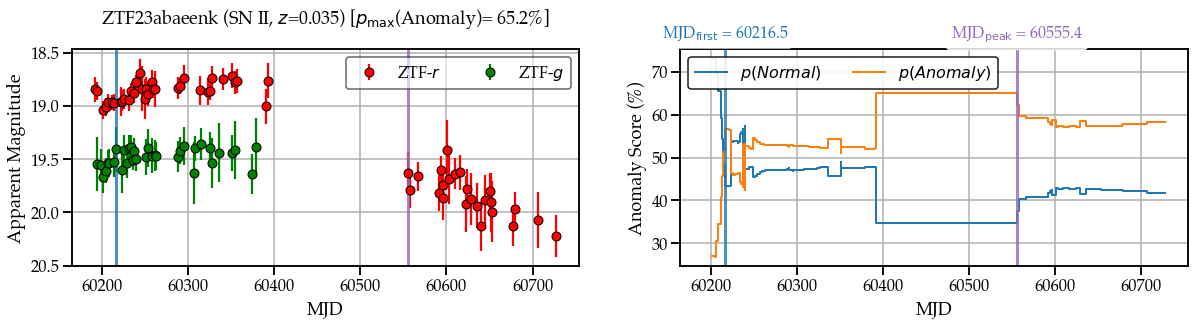

In [13]:
from relaiss.anomaly import anomaly_detection

# Run anomaly detection on a transient
(mjd_scores, anom_scores, norm_scores) = anomaly_detection(
    client=client,
    transient_ztf_id="ZTF23abaeenk",
    lc_features=client.lc_features,
    host_features=[],
    path_to_timeseries_folder="./laiss_final/timeseries",
    path_to_sfd_folder='./sfddata-master',
    path_to_dataset_bank=client.bank_csv,
    path_to_models_directory="./laiss_final/models",
    path_to_figure_directory="./laiss_final/figures/direct_example",
    save_figures=True,
    return_scores=True,
    anom_thresh=50,
    force_retrain=True,
    preprocessed_df=None
)

print("Anomaly detection figures saved to ./figures/AD/")

## Next Steps

To explore more advanced features, check out the `advanced_usage.ipynb` notebook which covers:
- Using PCA for dimensionality reduction
- Creating theorized lightcurves
- Swapping host galaxies
- Setting maximum neighbor distances
- Tweaking ANNOY parameters
- Making corner plots
- Advanced anomaly detection techniques